# Visualizing multivariate, spatio-temporal information in the Cloud with widgets

---

## Overview

A common need of geoscientists is to diagnose their favorite system's behavior in space and time across multiple variables. An example is the response of the climate system to explosive volcanism, which cools climate in the years that follow a large eruption. Effects can reverberate for several years across multiple variables, and building tools to visually track this information can be daunting. Inspired by the [VICS working group](https://pastglobalchanges.org/science/wg/vics/intro), this notebook shows how to build widgets that allow to probe the relationship between volcanism and climate over the Common Era.  This notebook shows how to:


1. Plot Hovmuller diagram of SAOD
1. Plot timeseries of global average SAOD550
1. Composing a dashboard
1. Making a dashboard navigable with widgets

<font color=green> 
- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate. </font>

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from pathlib import Path
import numpy as np
import cftime
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import ipywidgets as widgets

## Optical properties of volcanic aerosols
Here we will use the eVolv2k EVA AOD data [Toohey and Sigl, 2017]. These data have dimensions of latitude (degrees north) and time (fractional years), which warrants investigation in continuous space, but also we will eventually want to convert to a global yearly average. Excellent! A teachable moment awaits! First, we'll load some data using Xarray.

In [2]:
vol_data = 'eVolv2k_v3_EVA_AOD_-500_1900_1.nc'
vol_ds = xr.open_dataset(Path(os.getcwd()).parent.parent/'data'/vol_data)

In [3]:
vol_ds = vol_ds.assign(lat_rad=np.deg2rad(vol_ds.lat))
vol_ds = vol_ds.set_coords(['lat_rad'])
vol_ds

<xarray.Dataset>
Dimensions:  (time: 28812, lat: 96)
Coordinates:
  * time     (time) float32 -500.0 -499.9 -499.8 ... 1.901e+03 1.901e+03
  * lat      (lat) float32 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
    lat_rad  (lat) float32 1.546 1.514 1.481 1.449 ... -1.481 -1.514 -1.546
Data variables:
    aod550   (time, lat) float32 ...
    reff     (time, lat) float32 ...
Attributes:
    title:                         EVA v1.2: stratospheric AOD
    EVA_reference:                 Toohey, M., Stevens, B., Schmidt, H., and ...
    EVA_source_code:               https://github.com/matthew2e/easy-volcanic...
    input_vssi_file:               eVolv2k_v3_ds_1.nc
    input_sulfate_parameter_file:  EVAv1_parameter_set_piBG.nc
    input_forcing_parameter_file:  EVAv1_parameter_set_piBG.nc
    input_grid_file:               eva_gridfile_echam_T63_sw.nc
    input_Mie_file:                eva_Mie_lookuptables.nc
    history:                       Created on 15.07.2019 at 14:29:58

### Hovmüller diagram:`pcolor` plot
We don't have latitude-longitude pairs for `aod550` data, but given atmospheric mixing across latitude bands, it may be informative to plot variation in the stratospheric aerosol optical depth (SAOD) at a wavelength of 550 nm on a time-latitude grid. 

#### Components
This plot depends on figure, so we'll want to apply our colorbar approach from the prior plots, from the get-go. Thus, we need:
- figure + gridspec (with slots for the figure and colorbar)
- a scalar mappable (generated with `make_scalar_mappable()`)
- meshgrid
- pcolor

Somewhat similarly to how we constructed an appropriate coordinate system for the filled contour plots using the cyclic_point, we can pass two vectors to `np.meshgrid()` to create the components of grid that underpins our `pcolor` plot. Then, also like the filled contour plots, all we need to do is pass the grid components, a matrix of values, and information about the color scheme to `ax.pcolor()`, and we'll be on our way!

In [4]:
# consider a window around a year of interest
before, after = 2, 5
erup_yr=940

itmp_slice = vol_ds.sel({'time':slice(erup_yr-before, erup_yr+after)})

If we wanted the coloring to be scaled to the data in this specific interval, we could use local minimum and maximum values:

In [5]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if n is None:
        ax_cmap = plt.get_cmap(cmap)
    else:    
        ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [6]:
# interval specific color scale
vol_vlims = [itmp_slice.aod550.min().values.ravel()[0], itmp_slice.aod550.max().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')

However, If we wanted this figure to maintain the same colorscale regardless of the `erup_yr`, we could use the minimum and maximum values of all the SAOD variation data to calculate our `scalar_mappable`.  

In [7]:
# general color scale
vol_vlims = [vol_ds.aod550.min().values.ravel()[0], vol_ds.aod550.max().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')

Now we'll use `np.meshgrid()` to construct a time-latitude (in radians) grid.  

In [8]:
t, l = np.meshgrid(itmp_slice.time,itmp_slice.lat_rad)

/var/folders/8f/31mjs7t50z73h7x1sf90w8040000gn/T/ipykernel_32614/3920750907.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set(**ax0_axformatting_d)


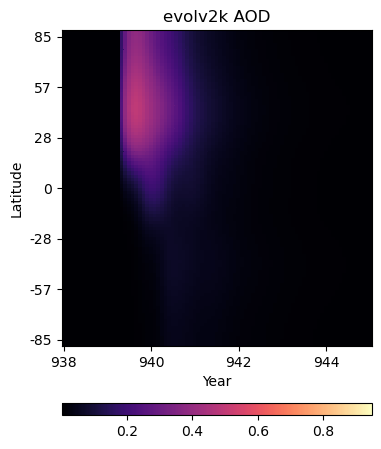

In [9]:
fig = plt.figure(figsize=(4, 5))
# 2 rows, 1 column, .05 space between rows, 8:.3 ratio of top row to bottom row
gs = gridspec.GridSpec(2, 1, hspace=0.35, height_ratios=[8, .3])
    
# evolv2k AOD
ax0 = fig.add_subplot(gs[0, 0])
pc = ax0.pcolor(t, l,itmp_slice.aod550.data.T, cmap=ax0_sm.cmap, norm=ax0_sm.norm)
# write ticks in degrees
tick_deg = [int(np.rad2deg(tick)) for tick in ax0.get_yticks()]
ax0_axformatting_d = {'ylabel':'Latitude', 
                      'yticklabels':map(str, tick_deg), 
                    'xlabel':'Year'}
ax0.set(**ax0_axformatting_d)
ax0.set_title(r'evolv2k AOD')

# colorbar
ax0c = fig.add_subplot(gs[1, 0])
ax0_cb = plt.colorbar(ax0_sm, cax=ax0c, orientation='horizontal')

### Global average SAOD550 variation timeseries
In conjunction with a pcolor plot, it can be useful to look at the evolution of a summary statistic like the global mean. The `time` dimension of this dataset is different from that in the LMR data. The attributes say that it is in "fractional year (ISO 8601, including year 0)", which, with a little inspection, we see means that there are 12 values per year (monthly) reported at the beginning of each month. Our goal is to bring this data onto the same timescale as the LMR data (yearly), and the easiest way to do this will be to group by year, and take the mean. 

_Side note: The study of history goes from 1BCE to 1CE without hesitation, but this poses some challenges mathematically with timeseries. Thus, we'll stick to the standard astronomical calendar, which stricks a year 0 in between._

In [10]:
vol_ds.time

<xarray.DataArray 'time' (time: 28812)>
array([-500.     , -499.91666, -499.83334, ..., 1900.75   , 1900.8334 ,
       1900.9166 ], dtype=float32)
Coordinates:
  * time     (time) float32 -500.0 -499.9 -499.8 ... 1.901e+03 1.901e+03
Attributes:
    long_name:  fractional year (ISO 8601, including year 0)
    units:      year

In [11]:
vol_ds['year'] = (('time'), np.add(vol_ds.time.data, 1/24).astype(int))

### Weighted Mean

In [12]:
vol_ds_weighted = vol_ds.copy()

In [13]:
lat_weights = np.cos(vol_ds_weighted.lat_rad)
lat_weights.name = "lat_weights"

vol_ds_weighted['weighted_aod550'] = (('time', 'lat'), (vol_ds_weighted['aod550']*lat_weights).data)
vol_ds_weighted = vol_ds_weighted.set_coords(['year'])

We can finally use `groupby('year').mean().mean(dim='lat')` to first calculate the weights-applied latitude-wise yearly average, and then calculate the global yearly average.

In [14]:
vol_ds_year_wm = vol_ds_weighted.groupby('year').mean().mean(dim='lat')
vol_ds_year_wm

<xarray.Dataset>
Dimensions:          (year: 2400)
Coordinates:
  * year             (year) int64 -499 -498 -497 -496 ... 1897 1898 1899 1900
Data variables:
    aod550           (year) float32 0.002833 0.002861 ... 0.002903 0.002903
    reff             (year) float32 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    weighted_aod550  (year) float32 0.001826 0.001836 ... 0.001863 0.001863

Let's put the `pcolor` plot above in a grid with the corresponding time segment of the global average timeseries. There are only two new plotting notes:
1. the `gridspec` has four slots to accommodate the pcolor plot and its colorbar, the timeseries, and an empty slot to act as a buffer between the colorbar and the timeseries
2. `ax1.sharex(ax0)` ensures that the two plots will share the same x-axis

In [15]:
itmp_slice_yr = vol_ds_year_wm.sel(year=slice(int(erup_yr)-before, int(erup_yr)+after))

In the same category as applying latitude-based weights to calculate a more accurate global average, let's revisit the spacing of the latitude axis of our SAOD (lat, time) Hovmüller diagram (our pcolor plot). By using sin(lat) as the y coordinate on a plot like this, the actual area of the globe covered by a given latitude band is preserved, allowing us to "integrate by eye" and better gauge the contribution of each latitude band to the total.

We'll stow these new tick locations, and tick labels in degrees north, along with other axis information a dictionary to efficiently update the axes.

In [16]:
tick_lat = np.arange(-80,100,20)
sin_ticks = np.sin(tick_lat*np.pi/180)

ax0_axformatting_d = {'ylabel':'Latitude', 
                       'ylim':[min(sin_ticks), max(sin_ticks)], 
                       'yticks':sin_ticks, 'yticklabels':map(str, tick_lat)}

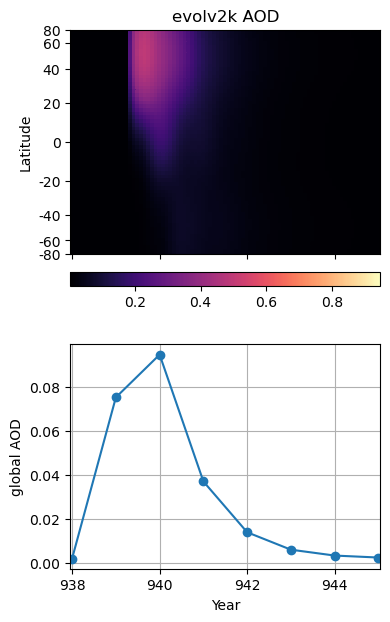

In [17]:
fig = plt.figure(figsize=(4, 7))
# 3 rows, 1 column, .15 space between rows, 8:.3 ratio of top row to bottom row
gs = gridspec.GridSpec(4, 1, hspace=0.15, height_ratios=[5, .3, .5, 5])

# evolv2k AOD
# pcolor
ax0 = fig.add_subplot(gs[0, 0])
pc = ax0.pcolor(t, l,itmp_slice.aod550.data.T, cmap=ax0_sm.cmap, norm=ax0_sm.norm)
ax0.set_title(r'evolv2k AOD')
ax0.set(**ax0_axformatting_d)

# colorbar
ax0c = fig.add_subplot(gs[1, 0])
ax0_cb = plt.colorbar(ax0_sm, cax=ax0c, orientation='horizontal')


# timeseries
ax1 = fig.add_subplot(gs[3, 0])
ax1.sharex(ax0)

ax1.plot(itmp_slice_yr.year,itmp_slice_yr.weighted_aod550,'-o')
ax1.grid(which='both')
ax1.set(**{'ylabel':'global AOD', 'xlabel':'Year'})

ax0.tick_params(labelbottom=False)

## The Last Millennium Reanalysis Project (LMR)

For a deeper discussion of LMR, check out our science bit about [CMIP6 and LMR](CMIP6_LMR.md). The gridded output from the Last Millenium Reanalysis Project is (happily) available via Pangeo-Forge. 

This LMR data set contains output for 20 Monte Carlo simulations (`MCrun`) run on a 2x2 degree latitude-longitude grid. Monte Carlo simulations are a useful way of acknowledging that we don't know exactly how climate evolved, but the group characteristics of multiple possible trajectories are more likely to capture the underlying story. 

_**[Pangeo-Forge](https://pangeo-forge.org/)**:_

Briefly, Pangeo-Forge is a project that makes it easy to access large datasets (often stored in many parts) via a url, and work with them without having to maintain local copies of the data--good for the hard drive, good for the RAM! For more information about Pangeo-Forge, the intrepid reader might appreciate their much more nuanced tutorials available [here](https://github.com/pangeo-forge/pangeo-forge-recipes/tree/94e87d4ae687020527ac25cefec776bcff352834/docs/introduction_tutorial).

In [18]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_gridded

,Array,Chunk
Bytes,2.44 GiB,1.25 MiB
Shape,"(2001, 20, 91, 180)","(1, 20, 91, 180)"
Count,2002 Tasks,2001 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.44 GiB,1.25 MiB
Shape,"(2001, 20, 91, 180)","(1, 20, 91, 180)"
Count,2002 Tasks,2001 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [19]:
# take the mean of all MC runs at each lat-lon point at each time
lmr_ds_gridded_mean = lmr_ds_gridded.mean(dim='MCrun')

In [20]:
# convert prate_mean from kg/(m^2*s) to mm/day
prate_unit_conversion = 86400
lmr_ds_gridded_mean=lmr_ds_gridded_mean.assign(prate_m=lmr_ds_gridded_mean['prate_mean'] * prate_unit_conversion)

In [21]:
# create a variable for year
lmr_ds_gridded_mean = lmr_ds_gridded_mean.assign(year=lmr_ds_gridded_mean['time'].dt.year)

In [22]:
# create a variable for latitude in radians
lmr_ds_gridded_mean= lmr_ds_gridded_mean.assign(lat_rad=np.deg2rad(lmr_ds_gridded_mean['lat']))

## Dashboard
The final goal of this notebook is to compose a dashboard of useful visualizations that might help us explore our data. Given evidence that volcanic emissions affect cloud formation and surface temperature, let's add spatial distributions of the surface air temperature and daily precipitation anomalies. In this case, the anomaly will be calculated relative to the immediate past to tease out any effect that might be directly related to an eruption event.  

The final dashboard will contain the Hovmüller diagram, the global average SAOD over time, and the two maps. The data displayed on the dashboard will be motivated by the user by way of either a dropdown menu initialized with a list of large volcanic eruptions, or a free text field in which a user can request the dashboard be recalculated for a year not included in the initial list. 

For more details about working with widgets, check out the [widget primer notebook](), but briefly we will need:
- an initial object or set of objects (like a figure with axes)
- a widget (or two)
- one or more function(s) describing what to do when the widget selection has changed (for a plot this often includes instructions about whether to keep or clear actions done by the previous selection and instructions about updating according to the current selection)

### Non-exhaustive list of volcanic events
The list of volcanic events below will provide a scope of events to investigate. This list is based on N-TREND analysis and meet the following criteria:
1. since 750 CE
2. a global forcing as large as Krakatoa
3. a tropical source
Each event with an identified source has a label in the `erup_names` list, all other events are associated with placeholding question marks. 

In [23]:
erup_yrs = [916,940,1108,1171,1191,1230,1258,1276,1286,1345,1453,1458,1595,1601,1641,1695,1784,1809,1816,1832,1836,1884]
erup_names = ['?','Eldgjá','UE 1108','?','?','UE 1230','Samalas','?',"Quilotoa","El Chichon","?",'Kuwae']
erup_names = erup_names + ["?","Huaynaputina","Parker","UE 1695","Laki","UE 1809","Tambora","?","?","Krakatau"]

n_events = len(erup_yrs)

erup_d = {erup_yrs[ik]:erup_names[ik] for ik in range(len(erup_yrs))}

A few misc parameters

In [24]:
# Set up plotting parameters
before = 2; after = 5; zrange = 40
nc = 21;  fnt='sans-serif'
view = 'global'

### Precompute anomalies

For the dashboard, we are specifically interested in the climate response to an event, so it makes sense to subtract the rolling mean from a short period prior. Xarray will once more come to the rescue with its `.rolling().mean()` function combination that specifies how the window should be selected and what should be done with the identified values (in the case of `.mean()`, they should be averaged). 

The function `make_demeaned()` selects data from the specified year and subtracts off the rolling average. 

In [25]:
rolling_mean = lmr_ds_gridded_mean[['hgt500_mean', 'air_mean', 'prate_m']].rolling(time=3, center=False).mean(dim='time')#.isel(time=slice(913,916))

def make_demeaned(erup_yr):
    time_arg1 = np.argwhere(lmr_ds_gridded_mean.time.dt.year.data>erup_yr)[0][0]-1
    demeaned = lmr_ds_gridded_mean[['hgt500_mean', 'air_mean', 'prate_m']].isel(time=time_arg1)-rolling_mean.isel(time=time_arg1-1)
    return demeaned

Sometimes widgets respond promptly, but sometimes they don't. For expediency, we'll pre-calculate de-meaned values for each of the events in the initial list. As part of that pre-compute, we'll build a list of max and min mean air temperature and precipitation rate values which will likely contain the bounding values (or close) that we will want to construct our color scales.

In [26]:
demeaned_d = {}
air_lim = []
prate_lim = []

for erup_yr in erup_yrs:    
    demeaned_d[erup_yr]= make_demeaned(erup_yr)
    air_lim += [demeaned_d[erup_yr]['air_mean'].max().values.ravel()[0], 
                demeaned_d[erup_yr]['air_mean'].min().values.ravel()[0]]

    prate_lim += [demeaned_d[erup_yr]['prate_m'].max().values.ravel()[0], 
                demeaned_d[erup_yr]['prate_m'].min().values.ravel()[0]]


In order to cleanly update the dashboard, each subfigure will need to be cleared, have any axis configuration reapplied, and finally be replotted. It is not strictly necessary to split this into two functions, but splitting it into two functions, one that sets things up and another that plots, is a good habit for other widget use cases. 

### Building the dashboard

In [27]:
# Calculate scalar mappables (colorbars)
# evolv2k AOD
vol_vlims = [vol_ds.aod550.max().values.ravel()[0], vol_ds.aod550.min().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')

# LMR: temp
ax2_Li_1 = max(np.abs(air_lim))
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)

# LMR: precip
ax3_Li_1 = max(np.abs(prate_lim))
ax3_levels = np.around(np.linspace(-ax3_Li_1, ax3_Li_1, 15), decimals=2)
ax3_sm = make_scalar_mappable([ax3_Li_1, -ax3_Li_1], 'BrBG', 15)

In [28]:
tick_lat = np.arange(-80,100,20)
sin_ticks = np.sin(tick_lat*np.pi/180)
erup_yrs_array = np.array(erup_yrs)
width = 7
        

# plot the data for the four frames
def plot(val):
    ax0_cmap = plt.get_cmap('magma')
    erup_yr = val
    erup_yrs_array = np.array(erup_yrs)
    
    if erup_yr not in erup_yrs:
        prev_erup_ind = np.argmin(erup_yrs_array<erup_yr)-1
        prev_erup_yr = erup_yrs_array[prev_erup_ind]
        erup_name = erup_d[prev_erup_yr]
        title = 'Year={}, {} years after {} eruption ()'.format(erup_yr, erup_yr-prev_erup_yr, erup_name, prev_erup_yr) 
    else:
        erup_name = erup_d[erup_yr]
        title = 'Year={}, immediate response to {} eruption'.format(erup_yr, erup_name)

    # pcolor
    itmp_slice = vol_ds.sel(time=slice(erup_yr-before, erup_yr+after))
    t, l = np.meshgrid(itmp_slice.time,itmp_slice.lat_rad)
    pc = ax0.pcolor(t, l,itmp_slice.aod550.data.T, cmap=ax0_sm.cmap, norm=ax0_sm.norm)
    ax0.set_title(r'evolv2k AOD',fontname=fnt)
    
    # timeseries
    itmp_slice_yr = vol_ds_year_wm.sel(year=slice(int(erup_yr)-before, int(erup_yr)+after))
    ax1.plot(itmp_slice_yr.year,itmp_slice_yr.weighted_aod550,'-o')
    ax1.grid(which='both')
    
    ax0.tick_params(labelbottom=False)
    
    # maps
    demeaned = demeaned_d[erup_yr]                     
    tas_c, lonc = cutil.add_cyclic_point(demeaned['air_mean'], demeaned['lon'])
    zg_c , _ = cutil.add_cyclic_point(demeaned['hgt500_mean'], demeaned['lon'])                     
    cf2 = ax2.contourf(lonc,demeaned['lat'],tas_c,nc, levels=ax2_levels, 
                       transform=ccrs.PlateCarree(), **cf2_kwargs)
    cf2_lines = ax2.contour(lonc,demeaned['lat'], zg_c, np.linspace(-zrange,zrange,15),
                            colors='k',
                            transform=ccrs.PlateCarree(), linewidths=.5)
    ax2.set_title(r'SAT Anomaly and $Z_{500}$',fontname=fnt)

    pr_c, lonc = cutil.add_cyclic_point(demeaned['prate_m'], demeaned['lon'])
    cf3 = ax3.contourf(lonc,demeaned['lat'],pr_c,nc, transform=ccrs.PlateCarree(), 
                       levels=ax3_levels, **cf3_kwargs)
    ax3.set_title(r'Precipitation Anomaly',fontname=fnt)
    
    fig.suptitle(title,fontsize=13*width/6,fontname=fnt)

# clear and reset the axis configurations
def reset_axes_plot(val):
    ax0.set(**{'ylabel':'Latitude', 
               'ylim':[min(sin_ticks), max(sin_ticks)], 
               'yticks':sin_ticks, 'yticklabels':map(str, tick_lat)})
    
    ax1.set(**{'ylabel':'global AOD'})
    
    ax2.set_global()
    ax2.add_feature(cfeature.COASTLINE, edgecolor='k')

    ax3.set_global()
    ax3.add_feature(cfeature.COASTLINE, edgecolor='k')

    if type(val) == int:
        plot(val)
    else:
        plot(int(val.new))

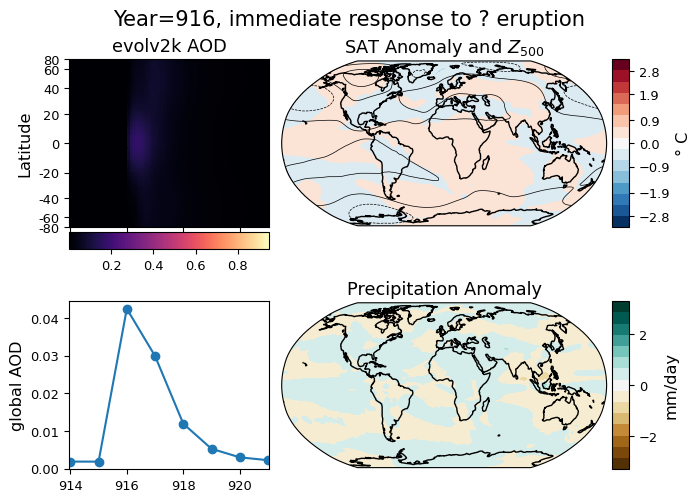

In [29]:
# %matplotlib ipympl
# if using jupyter notebook rather than jupyer lab, use %matplotlib notebook
plt.close('all')
width, height = 7, 5

div = 6
plt.rcParams.update({'ytick.labelsize':8*width/div, 'xtick.labelsize':8*width/div, 
                          'axes.titlesize':11*width/div,  'axes.labelsize':10*width/div})

fig = plt.figure(figsize=(width, height))#subplots(3,2,figsize=(12,6))#,sharex=True)
gs = gridspec.GridSpec(4, 5, bottom=.06, top=.88, right=.9,left=.1, wspace=0,hspace=.05,
                       width_ratios=[.8, .05,1.3,.02,.07], height_ratios=[1,.1,.25,1])

# evolv2k AOD
ax0 = fig.add_subplot(gs[0, 0])
ax0c = fig.add_subplot(gs[1, 0])
ax0_cb = plt.colorbar(ax0_sm,cax=ax0c, orientation='horizontal')

ax1 = fig.add_subplot(gs[3, 0])
ax1.sharex(ax0)
ax1.grid(which='both')

# LMR
# temp                     
ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson(central_longitude=0))
ax2c = fig.add_subplot(gs[0, 4])
cb2 = plt.colorbar(ax2_sm,cax=ax2c, orientation='vertical',label="\xb0 C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

# precip                     
ax3 = fig.add_subplot(gs[3, 2], projection=ccrs.Robinson(central_longitude=0))
ax3c = fig.add_subplot(gs[3, 4])                     
cb3 = plt.colorbar(ax3_sm,cax=ax3c, orientation='vertical',label='mm/day')
cb3.minorticks_off()
cf3_kwargs = {'cmap':ax3_sm.cmap,
             'norm':ax3_sm.norm}  

# initial plot
valinit = 0
reset_axes_plot(erup_yrs[valinit])

### Adding widget control to the dashboard

Here we initialize two widgets: a dropdown initially populated by the list of `erup_yrs`,  a free text box that allows you to enter a year not included in that list and a container to put them both in.

In [30]:
%matplotlib ipympl
# if using jupyter notebook rather than jupyer lab, use %matplotlib notebook

# dropdown with major volcanic events
dropdown = widgets.Dropdown(
    value=erup_yrs[0], 
    options=erup_yrs, 
    description='Eruption', 
    layout={'width': 'initial'}
)

# free text field look at a year outside of dropdown options
year_input = widgets.Text(value='', 
                          description='Enter a year (916-1900 CE):', 
                          style={'description_width':  'initial'},
                          continuous_update=False)

# box to hold the dropdown widget and free text field
options = widgets.HBox([dropdown, year_input], layout=widgets.Layout(
    display='flex', justify_content='space-around', width='70%'))

`update_from_dropdown` updates the plots based on the selection made from the dropdown.

`update_from_freefield` updates the plots according to the year typed into the text field, and adds the year (indicated with an astrisk) to the dropdown.  This extra functionality allows you to view a year not included in the original set, and add it to the working set without needing maintain a mental list of which years came from which source.

In [31]:
def update_from_dropdown(val):
    ax0.cla()
    ax1.cla()    
    ax2.cla()
    ax3.cla()
    
    if type(val.new) == str:
        yr = int(val.new.replace('*', ''))
    else:
        yr = val.new
    
    reset_axes_plot(yr)
    fig.canvas.draw_idle()

def update_from_freefield(val):
    ax0.cla()
    ax1.cla()    
    ax2.cla()
    ax3.cla()
    
    demeaned_d[int(val.new)]=make_demeaned(int(val.new))
    opts = [str(key)+'*' if key not in erup_yrs else str(key) for key in sorted(demeaned_d)]
    dropdown.options = opts
    dropdown.value= int(val.new) if int(val.new) in erup_yrs else str(int(val.new))+'*' 
    
    reset_axes_plot(int(val.new))
    fig.canvas.draw_idle()     

The cell below pulls all the parts together! The four plots are initialized in roughly the same way they were above (the scalar mappables here cover the full range of values included in the precomputed events, rather than being specific to a particular event as they were previously). The primary new information is the setting up the widgets to `observe` behavior. 
For example,
```
dropdown.observe(update_from_dropdown, 'value')
```
sets up the dropdown to pass the selected value to the `update_from_dropdown()` function.

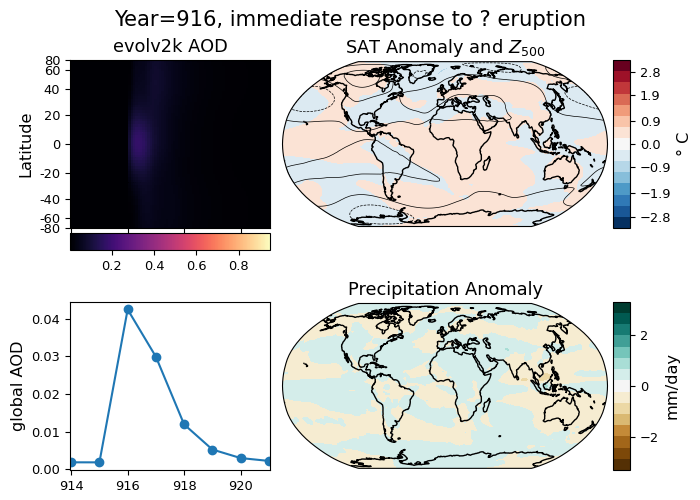

In [32]:
%matplotlib ipympl
# if using jupyter notebook rather than jupyer lab, use %matplotlib notebook
plt.close('all')
width, height = 7, 5

div = 6
plt.rcParams.update({'ytick.labelsize':8*width/div, 'xtick.labelsize':8*width/div, 
                          'axes.titlesize':11*width/div,  'axes.labelsize':10*width/div})

fig = plt.figure(figsize=(width, height))#subplots(3,2,figsize=(12,6))#,sharex=True)
gs = gridspec.GridSpec(4, 5, bottom=.06, top=.88, right=.9,left=.1, wspace=0,hspace=.05,
                       width_ratios=[.8, .05,1.3,.02,.07], height_ratios=[1,.1,.25,1])

# evolv2k AOD
ax0 = fig.add_subplot(gs[0, 0])
ax0c = fig.add_subplot(gs[1, 0])
vol_vlims = [vol_ds.aod550.max().values.ravel()[0], vol_ds.aod550.min().values.ravel()[0]]
ax0_sm = make_scalar_mappable(vol_vlims, 'magma')
ax0_cb = plt.colorbar(ax0_sm,cax=ax0c, orientation='horizontal')

ax1 = fig.add_subplot(gs[3, 0])
ax1.sharex(ax0)
ax1.grid(which='both')

# LMR
# temp                     
ax2 = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson(central_longitude=0))
ax2c = fig.add_subplot(gs[0, 4])
ax2_Li_1 = max(np.abs(air_lim))
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cb2 = plt.colorbar(ax2_sm,cax=ax2c, orientation='vertical',label="\xb0 C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}

# precip                     
ax3 = fig.add_subplot(gs[3, 2], projection=ccrs.Robinson(central_longitude=0))
ax3c = fig.add_subplot(gs[3, 4])                     
ax3_Li_1 = max(np.abs(prate_lim))
ax3_levels = np.around(np.linspace(-ax3_Li_1, ax3_Li_1, 15), decimals=2)
ax3_sm = make_scalar_mappable([ax3_Li_1, -ax3_Li_1], 'BrBG', 15)
cb3 = plt.colorbar(ax3_sm,cax=ax3c, orientation='vertical',label='mm/day')
cb3.minorticks_off()
cf3_kwargs = {'cmap':ax3_sm.cmap,
             'norm':ax3_sm.norm}  

# initial plot
valinit = 0
reset_axes_plot(erup_yrs[valinit])

# initiate observing by widgets
dropdown.observe(update_from_dropdown, 'value')
year_input.observe(update_from_freefield, 'value')

# display widgets
widgets.VBox([options])

---

## Summary
And voila! A dashboard that can be explored via a dropdown! Hopefully this notebook showed that a dashboard is mostly a collection of simpler plots, but there are a few adjustments that can help tie axes together and widgets can make exploring a data set more space-efficient.

## Resources and references


| _For details, see_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |
|  Neukom, R., L. A. Barboza, M. P. Erb, F. Shi, J. Emile-Geay, M. N. Evans, J. Franke, D. S. Kaufman, L. Lücke, K. Rehfeld, A. Schurer, F. Zhu, S. Br ̈onnimann, G. J. Hakim, B. J. Henley, F. C. Ljungqvist, N. McKay, V. Valler, and L. von Gunten (2019), Consistent multidecadal variability in global temperature reconstructions and simulations over the common era, Nature Geoscience, 12(8), 643–649, doi:10.1038/s41561-019-0400-0. |
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|
|Toohey, M. and Sigl, M.: Volcanic stratospheric sulfur injections and aerosol optical depth from 500 BCE to 1900 CE, Earth Syst. Sci. Data, 9, 809–831, https://doi.org/10.5194/essd-9-809-2017, 2017.|